# Subsurface Imaging

Our code follows the approach from the paper "An approach to quantum-computational hydrologic inverse analysis" by Daniel O'Malley. 

Our goal is to devide a given subsurface into regions with high permeability $k_h$ and low permeability $k_l$.

In a first step, we define most of the relevant functions. 

We continue with the small 1D problem, which demonstrates the general procedure. Afterwards, we extend this to a larger problem and the 2D case. For all 3 parts the proceeding was similar: 

First we randomly generate binary valued ($k_l$,$k_h$) permeability data. Then we use a discretized version of the equation $\nabla (k\nabla h)=0$ to generate realistic hydraulic head values $h$.

After that we start with the actual inverse analysis by using an QAOA routine already available in Qiskit to extract the permeability $k$ from the given $h$ values.

For the large 1D problem we additionally performed a benchmarking.

In [1]:
# Import math functions (numpy) and sympy for creating formulars
from IPython.display import clear_output
import numpy as np
import sympy as sp
from fractions import Fraction
import matplotlib.pyplot as plt

In [2]:
# Import qiskit framework
from qiskit import IBMQ
from qiskit_optimization import QuadraticProgram
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import QAOA

In [7]:
#IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q')

In [3]:
clear_output()

## Define Functions

In [4]:
def construct_function(kl, kh, n, h):
    """Constructs the mathematical function to be optimized

    Args:
        kl (double): low permeability value 
        kh (double): high permeability value
        n (int): number of hydraulic heads
        h (list): values for each of the hydraulic heads

    Returns:
        sympyfunction, dict: mathematical sympy function with coefficients
    """
    function = 0
    sp.init_printing(use_unicode=True)
    
    # construct variables for each permeability
    for i in range(1,n):
        globals()['q%s' % i] = sp.symbols('q'+str(i))
        globals()['h%s' % i] = sp.symbols('q'+str(i))
        
    # for each permeability, add its contribution to the total cost function
    for i in range(2,n):
        term = ((kl+globals()['q%s' % (i-1)]*(kh-kl))*(h[i-2]-h[i-1])+(kl+globals()['q%s' % (i)]*(kh-kl))*(h[i]-h[i-1]))**2
        function = function + term
        
    # expand and simplify the cost function
    function = sp.expand(function)
    
    # convert all square terms into linear terms as qi^2 = qi = 0 or 1 for all i and simplify the cost function
    for i in range(1,n):
        function = function.subs(sp.symbols('q'+str(i))**2, (sp.symbols('q'+str(i))))
        coeffs = sp.Poly(function).as_dict()
        
    # function in sympy form and coefficients of all terms in an easily readble dictionary form returned
    return function, coeffs

In [5]:
def generate_QP(coeffs, n, verbose=False):
    """Generates the Quadratic Program to be optimized

    Args:
        coeffs (dict): Contains the coefficients from the sympy funciton
        n (int): Number of hydraulic heads

    Returns:
        QuadraticProgram: The quadratic program to optimize
    """
    qp = QuadraticProgram()   #Initialize a Qiskit Quadratic Program object
    for i in range(1,n):
        qp.binary_var('q'+str(i))     #Permeabilities ki are modeled by binary vairables qi
    constant = 0      # constant term
    linear = {}      # coefficients for linear terms
    quadratic = {}    # coefficients for coupling terms
    for key,value in coeffs.items():    # add coefficients to the corresponding dictionaries one by one
        if sum(key) == 0:
            constant = float(value)
        elif sum(key) == 1:
            term = 'q'+str(np.argmax(key)+1)
            linear[term] = float(value)
        else:
            indices = [i[0] for i in np.argwhere(np.array(key)>0)]
            term = ('q'+str(indices[0]+1),'q'+str(indices[1]+1))
            quadratic[term] = float(value)
    qp.minimize(linear=linear, quadratic=quadratic, constant=constant)     # run the optimization algorithm, find minimum value
    if verbose:
        print(qp.export_as_lp_string())    #make a printed report of the task
    return qp

In [6]:
def hydrologic_inverse_analysis(kl,kh,n,h, verbose=False):
    """Constructs and solves the mathematical function

    Args:
        kl (double): low permeability value
        kh (double): high permeability value
        n (int): number of hydraulic heads
        h (list): values for each of the hydraulic heads
        verbose (Bool): Output information or not

    Returns:
        list: list with the estimated permeability values k for the hydraulic heads h
    """
    # Create the mathematical function
    function, coeffs = construct_function(kl,kh,n,h)
    if verbose:
        print('Function in Sympy:', function)
    # Generate the quadratic problem and solve it with Qiskit
    qp = generate_QP(coeffs,n,verbose)
    qins = QuantumInstance(backend=Aer.get_backend('qasm_simulator'), shots=1000, seed_simulator=123)
    meo = MinimumEigenOptimizer(min_eigen_solver=QAOA(reps=1, quantum_instance=qins))  # solve with QAOA algorithm,
    result = meo.solve(qp)    #could replace by classical solver and other quantum solvers
    if verbose:
        print('\nrun time:', result.min_eigen_solver_result.optimizer_time)
        print(result)
    k = [int(i) for i in list(kl+result.x*(kh-kl))]
    if verbose:
        print('k_res: ', k)
    return k

In [7]:
def evaluate_performance(k_true,k_res, verbose=False):
    """Evaluate the performance of the estimation by calculating missmatches and comparing them to the total number of values

    Args:
        k_true (list): True permeability values 
        k_res (list): Estimated permeability values
        verbose (Bool): Output information or not

    Returns:
        double: Error rate
    """
    total_number = len(k_true)
    false_count = 0
    for i in range(len(k_true)):
        if k_true[i] != k_res[i]:
            false_count += 1
    error_rate = false_count / total_number
    if verbose:
        print('Error Rate = '+ str(error_rate*100)+'%')
    return error_rate

In [28]:
def construct_function_2D(kl, kh, n, h):
    """Constructs the mathematical function to be optimized

    Args:
        kl (double): low permeability value
        kh (double): high permeability value
        n (int): number of hydraulic heads
        h (list): values for each of the hydraulic heads

    Returns:
        sympyfunction, dict: mathematical sympy function with coefficients
    """
    function = 0
    sp.init_printing(use_unicode=True)
    
    # construct variables for each permeability
    for i in range(1,n):
        for j in range(1,n+1):
            globals()['qy%s%s' %(i,j)] = sp.symbols('qy'+str(i)+str(j))
    for i in range(1,n+1):
        for j in range(1,n):
            globals()['qx%s%s' %(i,j)] = sp.symbols('qx'+str(i)+str(j))
        
    # for each permeability, add its contribution to the total cost function
    for i in range(2,n+1): 
        for j in range(2,n+1): 
            term = ((kl+globals()['qx%s%s' %(i-1,j-1)] *(kh-kl))*(h[i-1][j]-h[i][j])+(kl+globals()['qx%s%s' %(i,j-1)] *(kh-kl))*(h[i+1][j]-h[i][j])+(kl+globals()['qy%s%s' %(i-1,j-1)] *(kh-kl))*(h[i][j-1]-h[i][j])+(kl+globals()['qy%s%s' %(i-1,j)] *(kh-kl))*(h[i][j+1]-h[i][j]))**2
            function = function + term
        
    # expand and simplify the cost function
    function = sp.expand(function)
    
    # convert all square terms into linear terms as qi^2 = qi = 0 or 1 for all i and simplify the cost function
    for i in range(1,n+1):
        for j in range(1,n+1):
            function = function.subs(sp.symbols('qx'+str(i)+str(j))**2, (sp.symbols('qx'+str(i)+str(j))))
            function = function.subs(sp.symbols('qy'+str(i)+str(j))**2, (sp.symbols('qy'+str(i)+str(j))))
    coeffs = sp.Poly(function).as_dict()
    # function in sympy form and coefficients of all terms in an easily readble dictionary form returned
    return function, coeffs

In [9]:
def coefficients_order_2D(n):
    """Find the order of printed coefficients from sympy

    Args:
        n (int): number of hydraulic heads

    Returns:
        list: a list containing the name of the terms in str format corresponding to the coefficients in order
        eg. ['qx11','qx12','qx13','qx21', ...]
    """
    order_list = []
    for i in range(1,n+1):
        for j in range(1,n):
            order_list.append('qx'+str(i)+str(j))
    for i in range(1,n):
        for j in range(1,n+1):
            order_list.append('qy'+str(i)+str(j))
    return order_list

In [10]:
def generate_QP_2D(coeffs, n, verbose=False):
    """Generates the Quadratic Program to be optimized

    Args:
        coeffs (dict): Contains the coefficients from the sympy funciton
        n (int): Number of hydraulic heads

    Returns:
        QuadraticProgram: The quadratic program to optimize
    """
    qp = QuadraticProgram()  #Initialize a Qiskit Quadratic Program object
    for i in range(1,n):
        for j in range(1,n+1):
            qp.binary_var('qy'+str(i)+str(j))
    for i in range(1,n+1):
        for j in range(1,n):
            qp.binary_var('qx'+str(i)+str(j))    #Permeabilities kxij, kyij are modeled by binary vairables qxij, qyij
    constant = 0    # constant term
    linear = {}     # coefficients for linear terms
    quadratic = {}    # coefficients for coupling terms
    order_list = coefficients_order_2D(n)
    for key,value in coeffs.items():    # add coefficients to the corresponding dictionaries one by one
        if sum(key) == 0:
            constant = float(value)
        elif sum(key) == 1:
            term = order_list[np.argmax(key)]
            linear[term] = float(value)
        else:
            indices = [i[0] for i in np.argwhere(np.array(key)>0)]
            term = (order_list[indices[0]],order_list[indices[1]])
            quadratic[term] = float(value)
    qp.minimize(linear=linear, quadratic=quadratic, constant=constant)    # run the optimization algorithm, find minimum value
    if verbose:
        print(qp.export_as_lp_string())   #make a printed report of the task
    return qp

In [11]:
def hydrologic_inverse_analysis_2D(kl,kh,n,h, verbose=False):
    """Constructs and solves the mathematical function

    Args:
        kl (double): low permeability value
        kh (double): high permeability value
        n (int): number of hydraulic heads
        h (list): values for each of the hydraulic heads
        verbose (Bool): Output information or not

    Returns:
        list: list with the estimated permeability values k for the hydraulic heads h
    """
    # Create the mathematical function
    function, coeffs = construct_function_2D(kl,kh,n,h)
    if verbose:
        print('Function in Sympy:', function)
    # Generate the quadratic problem and solve it with Qiskit
    qp = generate_QP_2D(coeffs,n,verbose)
    qins = QuantumInstance(backend=Aer.get_backend('qasm_simulator'), shots=1000, seed_simulator=123)
    meo = MinimumEigenOptimizer(min_eigen_solver=QAOA(reps=1, quantum_instance=qins))   # solve with QAOA algorithm,
    result = meo.solve(qp)     #could replace by classical solver and other quantum solvers
    if verbose:
        print('\nrun time:', result.min_eigen_solver_result.optimizer_time)
        print(result)
    k = [int(i) for i in list(kl+result.x*(kh-kl))]
    kx= np.array(k[:n*(n-1)]).reshape((n,n-1))
    ky = np.array(k[n*(n-1):]).reshape((n-1,n))
    if verbose:
        print('kx_res: ', kx)
        print('ky_res: ', ky)
    return kx, ky

In [12]:
def evaluate_performance_2D(kx_true,ky_true,kx_res,ky_res, verbose=False):
    """Evaluate the performance of the estimation by calculating missmatches and comparing them to the total number of values

    Args:
        kx_true (list): True permeability values in x-direction 
        ky_true (list): True permeability values in y-direction
        kx_res (list): Estimated permeability values in x-direction
        ky_res (list): Estimated permeability values in y-direction
        verbose (Bool): Output information or not

    Returns:
        double: Error rate
    """
    total_number = 4*len(kx_true)
    false_count = np.sum(np.abs(kx_true-kx_res))+np.sum(np.abs(ky_true-ky_res))
    error_rate = false_count / total_number
    if verbose:
        print('Error Rate = '+ str(error_rate*100)+'%')
    print(false_count)
    
    return error_rate

## Small 1D Problem

Given: 3 heads with $h_1=1, h_2=\frac{1}{3}, h_3=0$ <br>
Assumption: $k_l = 1, k_h = 2$ <br>
Task: minimize  $f(q_1, q_2) = \frac{8}{9}q_1 − \frac{1}{9}q_2 − \frac{4}{9}q_1q_2 + \frac{1}{9}$

Data generation:

In [13]:
k_true = [1,2] #assumption values for k

In [14]:
kl = 1        # low permeability value
kh = 2        # high permeability value
n = 3         # number of hydraulic heads
h = [1,1/3,0] # values for each of the hydraulic heads

Inverse analysis:

In [15]:
k_res = hydrologic_inverse_analysis(kl,kh,n,h,verbose=True) #permeability results using QAOA

Function in Sympy: -0.444444444444444*q1*q2 + 0.888888888888889*q1 - 0.111111111111111*q2 + 0.111111111111111
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: 0.888888888889 q1 - 0.111111111111 q2 + [ - 0.888888888889 q1*q2 ]/2 +
      0.111111111111
Subject To

Bounds
 0 <= q1 <= 1
 0 <= q2 <= 1

Binaries
 q1 q2
End


run time: 0.031022071838378906
optimal function value: 2.7755575615628914e-17
optimal value: [0. 1.]
status: SUCCESS
k_res:  [1, 2]


Error rate:

In [16]:
error_rate = evaluate_performance(k_true, k_res, verbose=True) # error between calculated and assumed k values

Error Rate = 0.0%


## Larger 1D Problem

Data generation:

The hydraulic values are determined by given random binary valued permeability values via
$h_{i+1}=h_i+\frac{k_{i-1}}{k_i}(h_i - h_{i-1}).$

The equation is under-determined and needs two starting h values.

In [17]:
def generate_random_1D_data(kl, kh, n):
    """Generate random data for the value of the heads

    Args:

        kl (double): low permeability value
        kh (double): high permeability value
        n (int): number of hydraulic heads

    Returns:
        list, list: Returns the random true permeability values k and the corresponding hydraulic head values h
    """
    k_true = np.random.randint(2, size=n-1)*(kh-kl) +kl
    
    h=np.random.rand(2) # generation of two random starting values
    for i in range(1,n-1):
        h_next = h[i]+k_true[i-1]/k_true[i]*(h[i]-h[i-1])
        h=np.append(h, np.array([h_next]))
    return k_true, h

In [18]:
kl = 1 # low permeability value
kh = 2 # high permeability value 
n = 15 # number of hydraulic heads

In [19]:
# Generate a dataset with true k's and the hydraulic head values
k_true, h = generate_random_1D_data(kl, kh, n)
print("k =", k_true)
print("h =", h)

k = [2 1 1 1 2 2 2 2 1 2 1 1 1 2]
h = [0.46671309 0.50639648 0.58576328 0.66513007 0.74449687 0.78418026
 0.82386366 0.86354706 0.90323046 0.98259725 1.02228065 1.10164744
 1.18101423 1.26038103 1.30006443]


Inverse analysis:

In [20]:
# Estimate the k values, given only the head values
k_res = hydrologic_inverse_analysis(kl,kh,n,h,verbose=True)

Function in Sympy: -0.00629908799809494*q1*q2 - 0.00157477199952374*q1 - 0.00629908799809494*q10*q11 - 0.00629908799809494*q10*q9 - 0.00314954399904747*q10 - 0.0125981759961899*q11*q12 + 0.0188972639942848*q11 - 0.0125981759961899*q12*q13 + 0.0125981759961899*q12 - 0.00629908799809492*q13*q14 + 0.0188972639942848*q13 - 0.00157477199952374*q14 - 0.0125981759961899*q2*q3 + 0.0188972639942848*q2 - 0.0125981759961899*q3*q4 + 0.0125981759961899*q3 - 0.00629908799809494*q4*q5 + 0.0188972639942848*q4 - 0.00314954399904747*q5*q6 - 0.00314954399904747*q6*q7 + 0.00314954399904747*q6 - 0.00314954399904747*q7*q8 + 0.00314954399904747*q7 - 0.00629908799809494*q8*q9 + 0.0251963519923798*q9 + 0.00944863199714242
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: - 0.001574772000 q1 + 0.018897263994 q2 + 0.012598175996 q3
      + 0.018897263994 q4 + 0.003149543999 q6 + 0.003149543999 q7
      + 0.025196351992 q9 - 0.003149543999 q10 + 0.018897263994 q1

Error rate:

In [21]:
# Compare the estimation
error_rate = evaluate_performance(k_true, k_res, verbose=True)

Error Rate = 14.285714285714285%


Performance Analysis:

In this section we focus on the error analysis for the 1D problem.
The routine calculates the estimated error for a given number of heads.
The number of heads is increased to see the dependency of heads to the error rate.
Additionally the routine is run ten times to have a statistical average.

Current run:  1
Current run:  2
Current run:  3
Current run:  4
Current run:  5
Current run:  6
Current run:  7
Current run:  8
Current run:  9
Current run:  10


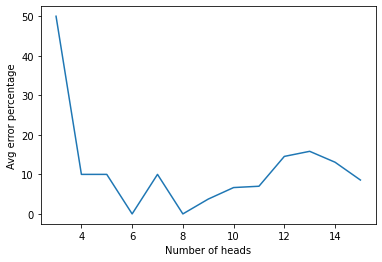

In [22]:
# Set everything up
runtime = 10
num_heads = 15
error_set = []
avg_set = []
# Start the runtime
for i in range(runtime):
    print("Current run: ", i+1)
    heads = []
    error_rates = []
    kl = 1
    kh = 2
    # Calculate the values for different amounts of heads
    for n in range(3,num_heads+1):
        k_true, h = generate_random_1D_data(kl, kh, n)
        k_res = hydrologic_inverse_analysis(kl, kh, n, h)
        error_rate = evaluate_performance(k_true, k_res)
        heads.append(len(h))
        error_rates.append(error_rate)
    error_set.append(error_rates)
# Do the statisics, take the average for each amount of heads
for i in range(num_heads-2):
    avg = 0
    for j in range(runtime):
        avg+=error_set[j][i]
    avg_set.append(avg/runtime*100)

plt.plot(heads, avg_set)
plt.xlabel("Number of heads")
plt.ylabel("Avg error percentage")
plt.show()

As one can see, the first data have a high error probability, which results from the low amount of heads. In that case it is either 0% error or 100% error, which results in the end in a rather high error probability. For later data one can see, that the error percentage drops to zero and then rises again. Here one can see, that for a larger dataset the errors start to increase.

## 2D Problem

Data generation:

Creation of extended random binary-valued $k_{x,ext}$ and $k_{y,ext}$ arrays with 2 columns and rows more than we will extract from the inverse analysis.
For the $h_{ext}$ we choose the first two rows and the left and right column with random values to calculate a fitting array for the $h$-values using the equation $h_{i+1,j}=h_{i,j}-\frac{k^x_{i-1,j-1}}{k^x_{i,j-1}}\cdot (h_{i-1,j}-h_{i,j})-\frac{k^y_{i-1,j-1}}{k^x_{i,j-1}}\cdot (h_{i,j-1}-h_{i,j})-\frac{k^y_{i-1,j}}{k^x_{i,j-1}}\cdot (h_{i,j+1}-h_{i,j}).$

In [23]:
dim=3
k_l=1 #low permeability value
k_h=2 #high permeability value

k_x_ext=np.random.randint(k_l, k_h+1, size=(dim+2, dim+1) )
k_y_ext=np.random.randint(k_l, k_h+1, size=(dim+1, dim+2) )
h_ext=np.random.rand(dim+2, dim+2) 

In [24]:
#above fields were used to obtain simulated hydraulic heads 
for i in range(1,dim+1):
    for j in range(1, dim+1):
        h_ext[i+1][j]=-(1/k_x_ext[i][j-1])*(k_x_ext[i-1][j-1]*h_ext[i-1][j]-
                      k_y_ext[i-1][j-1]*h_ext[i][j-1]-
                      k_y_ext[i-1][j]*h_ext[i][j+1]+
                      (k_x_ext[i-1][j-1]+k_x_ext[i][j-1]+k_y_ext[i-1][j]+k_y_ext[i-1][j-1])*h_ext[i][j])

k_x= k_x_ext[1:dim+1,1:dim]
k_y= k_y_ext[1:dim,1:dim+1]

Inverse analysis:

In [29]:
kx_res, ky_res = hydrologic_inverse_analysis_2D(kl, kh, dim, h_ext, verbose=True)

Function in Sympy: 2.09655868654504*qx11*qx21 + 0.983153488455328*qx11*qy11 + 1.27437438431084*qx11*qy12 + 4.49402560115963*qx11 + 72.3931561738453*qx12*qx22 + 19.505297062345*qx12*qy12 + 22.1476656638574*qx12*qy13 + 146.829215035232*qx12 + 573.557146870396*qx21*qx31 + 22.0943236340801*qx21*qy11 + 28.6389057340202*qx21*qy12 + 152.51186756371*qx21*qy21 + 124.769068729729*qx21*qy22 + 1045.01521936596*qx21 + 1347.7184725985*qx22*qx32 + 64.6087549492969*qx22*qy12 + 73.3612566371797*qx22*qy13 + 281.4763336867*qx22*qy22 + 174.994401087022*qx22*qy23 + 2733.93106579677*qx22 + 1856.58109834041*qx31*qy21 + 1518.85816075515*qx31*qy22 + 14422.1685076662*qx31 + 1581.99370970496*qx32*qy22 + 983.528661636598*qx32*qy23 + 15275.2021757077*qx32 + 13.4298363592888*qy11*qy12 + 52.0485750944694*qy11 + 19.766137839589*qy12*qy13 + 199.447011913174*qy12 + 148.940823671759*qy13 + 403.872388174588*qy21*qy22 + 3153.47739931182*qy21 + 205.413851172856*qy22*qy23 + 5107.60044300764*qy22 + 1555.49621867083*qy23 + 17

Error rate:

In [30]:
error_rate = evaluate_performance_2D(k_x,k_y,kx_res,ky_res, verbose=True)

Error Rate = 33.33333333333333%
4


The error rate is still very high and needs to be approved in further attempts. 

A possible starting point would be to change the data creation and probabliy even the discretization method since the appendencies of one h-value from the other discretized h-values appearing in the above written formula is difficult to implement in a structured way.